# Notebook de préparation au modèle d'estimation

## Imports et paramètrage

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
#import numpy as np
import matplotlib.pyplot as plt
from classes.credentials import Credentials as cr
from classes.split import Splitter
from classes.isolation_forest import IsolationForestClass
from classes.linear_regression import Linear_reg

splitter = Splitter()
isolation = IsolationForestClass()

In [2]:
valeurs2020 = pd.read_csv(cr.PATH+'2020.txt', sep='|', usecols=['Nature mutation', 'Code postal','Nombre pieces principales', 'Surface terrain', 'Valeur fonciere', 'Type local', 'Nombre de lots', 'Surface reelle bati'], encoding='utf-8')

## Nettoyage du dataset de biens immobiliers 2020
- Retirer les nuls
- Ploter
- Isolation forest

In [3]:
# Drop les lignes avec des nulles : type local, nombre lots, nb pièces, nature mutation, valeur foncière et CP
valeurs2020 = valeurs2020.dropna(subset = ['Type local', 'Nombre de lots', 'Nombre pieces principales', "Nature mutation", 'Valeur fonciere', 'Code postal'])

# On remplace les null de la surface de terrain par 0
valeurs2020['Surface terrain'] = valeurs2020['Surface terrain'].fillna(0) 

valeurs2020.head()

,Nature mutation,Valeur fonciere,Code postal,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain
11,Vente,"72000,00",1270.0,0,Maison,35.0,2.0,381.0
13,Vente,"180300,00",1000.0,0,Maison,75.0,4.0,525.0
14,Vente,"54800,00",1000.0,2,Appartement,32.0,1.0,0.0
16,Vente,"350750,00",1000.0,0,Maison,201.0,7.0,1267.0
17,Vente,"350750,00",1000.0,0,Maison,201.0,7.0,1497.0


In [4]:
# Premier tri, on garde les appartements et maisons, les ventes, un nombre de pièces principales supérieur à 0, 
# un nombre de lots inférieur à 6, surface réelle bâtie supérieure à 8 (minimum légal)
valeurs2020 = valeurs2020[[
    'Type local',
    'Code postal', 
    'Nombre pieces principales', 
    'Surface terrain', 
    'Surface reelle bati',
    'Valeur fonciere',
    'Nombre de lots'
    ]][valeurs2020['Type local'].str.contains("Appartement|Maison", regex=True)][valeurs2020['Nature mutation'].str.contains("Vente", regex=True)][valeurs2020['Nombre de lots']<6][valeurs2020['Nombre pieces principales']>0][valeurs2020['Surface reelle bati']>=8]


C:\Users\audre\AppData\Local\Temp/ipykernel_19832/4135512856.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valeurs2020 = valeurs2020[[


In [5]:
valeurs2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915817 entries, 11 to 2459557
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Type local                 915817 non-null  object 
 1   Code postal                915817 non-null  float64
 2   Nombre pieces principales  915817 non-null  float64
 3   Surface terrain            915817 non-null  float64
 4   Surface reelle bati        915817 non-null  float64
 5   Valeur fonciere            915817 non-null  object 
 6   Nombre de lots             915817 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 55.9+ MB


In [6]:
# Changement des virgules en points
valeurs2020[['Valeur fonciere']] = valeurs2020[['Valeur fonciere']].replace(',', '.', regex=True)

# Passage des objets en floats
valeurs2020[['Valeur fonciere']]  = valeurs2020[['Valeur fonciere']].astype('float')

valeurs2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915817 entries, 11 to 2459557
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Type local                 915817 non-null  object 
 1   Code postal                915817 non-null  float64
 2   Nombre pieces principales  915817 non-null  float64
 3   Surface terrain            915817 non-null  float64
 4   Surface reelle bati        915817 non-null  float64
 5   Valeur fonciere            915817 non-null  float64
 6   Nombre de lots             915817 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.9+ MB


In [7]:
valeurs2020.to_csv(cr.CURATED_LOCAL_PATH + 'filtreValeurs.csv', index=False)

## Split du dataset en départements

In [8]:
splitter.split_datas('filtreValeurs.csv', 'Type local', 'Train', '|')


## Test de l'isolation forest sur le dataset des appartements

In [9]:
df_apt = pd.read_csv(cr.CURATED_LOCAL_PATH + '/Train/Appartement.csv', sep='|', encoding='utf-8')
df_apt.head()

,Type local,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere,Nombre de lots
0,Appartement,1000.0,1.0,0.0,32.0,54800.0,2
1,Appartement,1270.0,2.0,195.0,50.0,53650.0,0
2,Appartement,1270.0,2.0,195.0,45.0,53650.0,0
3,Appartement,1000.0,3.0,0.0,92.0,97000.0,1
4,Appartement,1000.0,3.0,0.0,74.0,96000.0,2


In [10]:
isolation.isolation_forest_testing(cr.CURATED_LOCAL_PATH + '/Train/Appartement.csv', cr.CURATED_LOCAL_PATH + '/Train/Appartement_if_test.csv', '|')

    Type local  Code postal  Nombre pieces principales  Surface terrain  \
0  Appartement       1000.0                        1.0              0.0   
1  Appartement       1270.0                        2.0            195.0   
2  Appartement       1270.0                        2.0            195.0   
3  Appartement       1000.0                        3.0              0.0   
4  Appartement       1000.0                        3.0              0.0   
5  Appartement       1000.0                        4.0              0.0   
6  Appartement       1340.0                        3.0            746.0   
7  Appartement       1340.0                        5.0            746.0   
8  Appartement       1000.0                        2.0              0.0   
9  Appartement       1160.0                        5.0             73.0   

   Surface reelle bati  Valeur fonciere  Nombre de lots    scores  anomaly  
0                 32.0          54800.0               2  0.024640        1  
1                 50

In [11]:
# Import du CSV avec le score de l'IF
df_apt_testif = pd.read_csv(cr.CURATED_LOCAL_PATH + '/Train/Appartement_if_test.csv', usecols=['Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Valeur fonciere', 'Nombre de lots', 'scores', 'anomaly'])
df_apt_testif.head()

,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Valeur fonciere,Nombre de lots,scores,anomaly
0,1000.0,1.0,0.0,32.0,54800.0,2,0.024640,1
1,1270.0,2.0,195.0,50.0,53650.0,0,0.015137,1
2,1270.0,2.0,195.0,45.0,53650.0,0,0.020647,1
3,1000.0,3.0,0.0,92.0,97000.0,1,0.046117,1
4,1000.0,3.0,0.0,74.0,96000.0,2,0.056185,1


In [12]:
# Vérification du nombre de valeurs
print("df_apt_testif ", len(df_apt_testif), " rows")
print("Anomalies ", len(df_apt_testif[df_apt_testif['anomaly']==-1]), " rows")

df_apt_testif  391515  rows
Anomalies  37011  rows


In [13]:
# Suppression des anomalies
df_apt_testif = df_apt_testif[['Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Nombre de lots', 'Valeur fonciere']][df_apt_testif["anomaly"] != -1]

In [14]:
# Retrait des 10% de valeurs les plus hautes et 10% des valeurs les plus basses
df_apt_testif = df_apt_testif[df_apt_testif['Valeur fonciere'].between(df_apt_testif['Valeur fonciere'].quantile(.10), df_apt_testif['Valeur fonciere'].quantile(.90))]

## Tests à l'échelle du département du Puy-de-Dôme

In [15]:
# Sélection de l'échantillon
df_apt_63 = df_apt_testif[df_apt_testif['Code postal']>=63000][df_apt_testif['Code postal']<64000]

C:\Users\audre\AppData\Local\Temp/ipykernel_19832/2235199967.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_apt_63 = df_apt_testif[df_apt_testif['Code postal']>=63000][df_apt_testif['Code postal']<64000]


<AxesSubplot:>

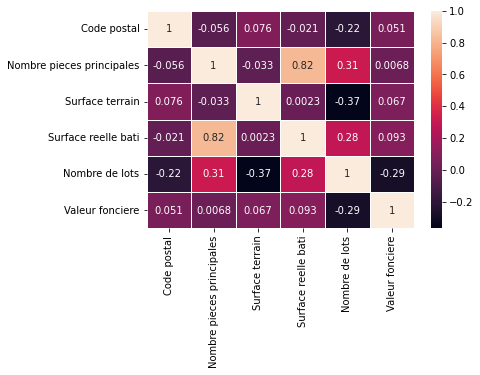

In [16]:
# Correlation
data_corr_train = df_apt_63.corr()
sns.heatmap(data_corr_train, linewidths=.5, annot=True)

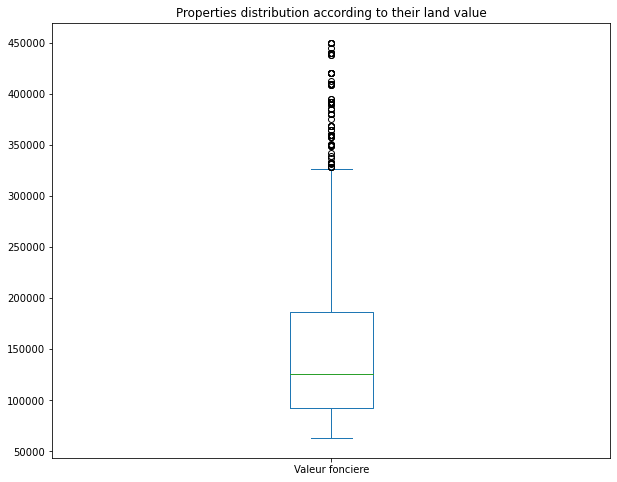

In [17]:
df_apt_63['Valeur fonciere'].plot(kind = 'box', title = 'Properties distribution according to their land value', figsize = (10, 8))
plt.show()

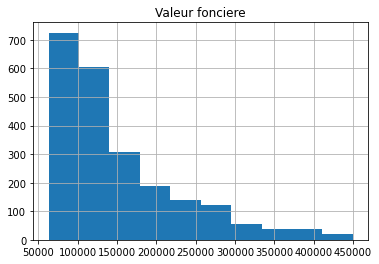

In [18]:
hist = df_apt_63.hist(column='Valeur fonciere')

## Utilisation de la méthode d'isolation forest principale sur les datasets d'appartements et maisons

In [19]:
isolation.isolation_forest(cr.CURATED_LOCAL_PATH + '/Train/Appartement.csv', sep='|')
isolation.isolation_forest(cr.CURATED_LOCAL_PATH + '/Train/Maison.csv', sep='|')

df_apt = pd.read_csv(cr.CURATED_LOCAL_PATH + '/Train/Appartement.csv', sep=',', encoding='utf-8')
df_maisons = pd.read_csv(cr.CURATED_LOCAL_PATH + '/Train/Maison.csv', sep=',', encoding='utf-8')

df_apt_test = df_apt[:10]
df_maisons_test = df_maisons[:10]

df_apt_test.to_csv(cr.TEST_PATH + 'Appartement.csv', sep='|', index=False, encoding='utf-8')
df_maisons_test.to_csv(cr.TEST_PATH + 'Maison.csv', sep='|', index=False, encoding='utf-8')

## Etalonage d'un modèle de régression linéaire

In [20]:
# Instanciation du modèle
linear_reg = Linear_reg()

# Split en train et test sets
train_features, test_features, train_labels, test_labels = linear_reg.train_test_split('maison', ',')

In [21]:
# Entrainnement du modèle
linear_reg.train(train_features, train_labels)

## Test du modèle

In [22]:
linear_reg.get_metrics(test_features, test_labels)

Mean squared error:  5733031238.384098 
Variance regression score function:  0.08925563928113511 
Maximum residual error:  418260.190281978 
Mean absolute error regression loss:  61928.57307850708


In [28]:
# Prédictions sur un jeu de test
df_maisons_test_set = pd.read_csv(cr.TEST_PATH + "/Maison.csv", sep="|", usecols=['Nombre pieces principales', 'Surface terrain', 'Surface reelle bati', 'Code postal', 'Nombre de lots'], encoding="utf-8")
linear_reg.predict(df_maisons_test_set)
df_maisons_test_set.head()


,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Nombre de lots,Valeur fonciere estimee
0,1000.0,4.0,525.0,75.0,0,160217.0
1,1250.0,4.0,790.0,93.0,0,170539.0
2,1310.0,5.0,1350.0,90.0,0,172245.0
3,1310.0,5.0,360.0,90.0,0,172245.0
4,1310.0,5.0,1430.0,90.0,0,172245.0


In [24]:
# Vérification des valeurs
df_maisons.head()

,Unnamed: 0,Code postal,Nombre pieces principales,Surface terrain,Surface reelle bati,Nombre de lots,Valeur fonciere
0,1,1000.0,4.0,525.0,75.0,0,180300.0
1,4,1250.0,4.0,790.0,93.0,0,215000.0
2,5,1310.0,5.0,1350.0,90.0,0,179210.0
3,6,1310.0,5.0,360.0,90.0,0,179210.0
4,7,1310.0,5.0,1430.0,90.0,0,179210.0


## Prédiction d'une valeur foncière avec des features personnalisées

In [32]:
print(linear_reg.predict_value(50, 3, 195, 3, 63000))

[8.69657394e+08]
